# Flight Data Variables and Definition

1. **Year** 2008
2. **Month** 1-12
3. **DayofMonth** 1-31
4. **DayOfWeek** 1 (Monday) - 7 (Sunday)
5. **DepTime** actual departure time (local, hhmm)
6. **CRSDepTime** scheduled departure time (local, hhmm)
7. **ArrTime** actual arrival time (local, hhmm)
8. **CRSArrTime** scheduled arrival time (local, hhmm)
9. **UniqueCarrier** unique carrier code
10. **FlightNum** flight number
11. **TailNum** plane tail number: aircraft registration, unique aircraft identifier
12. **ActualElapsedTime** in minutes
13. **CRSElapsedTime** in minutes
14. **AirTime** in minutes
15. **ArrDelay** arrival delay, in minutes
16. **DepDelay** departure delay, in minutes
17. **Origin** origin IATA airport code
18. **Dest** destination IATA airport code
19. **Distance** in miles
20. **TaxiIn** taxi in time, in minutes
21. **TaxiOut** taxi out time in minutes
22. **Cancelled** *was the flight cancelled
23. **CancellationCode** reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. **Diverted** 1 = yes, 0 = no
25. **CarrierDelay** in minutes
26. **WeatherDelay** in minutes
27. **NASDelay** in minutes
28. **SecurityDelay** in minutes
29. **LateAircraftDelay** in minutes

# The majority of the exploratory data analysis (EDA) presented in this work is based on the comprehensive and meticulous EDA conducted by Adrian Veras. While I have made certain adaptations and added my own insights, I would like to explicitly acknowledge and give credit to Adrian Veras for his foundational contributions to the dataset's exploration.

# Data Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.options.display.float_format = '{:.0f}'.format

In [2]:
flights = pd.read_csv('/kaggle/input/delayflights/DelayedFlights.csv')

flights.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003,1955,2211,2225,WN,...,4,8,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754,735,1002,1000,WN,...,5,10,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628,620,804,750,WN,...,3,17,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829,1755,1959,1925,WN,...,3,10,0,N,0,2,0,0,0,32
4,5,2008,1,3,4,1940,1915,2121,2110,WN,...,4,10,0,N,0,NaN,NaN,NaN,NaN,NaN


**Correlation Heatmap**

To understand how different numeric variables in our dataset are correlated, we visualize it using a heatmap. This heatmap helps in identifying features that might be of importance for our further analysis.

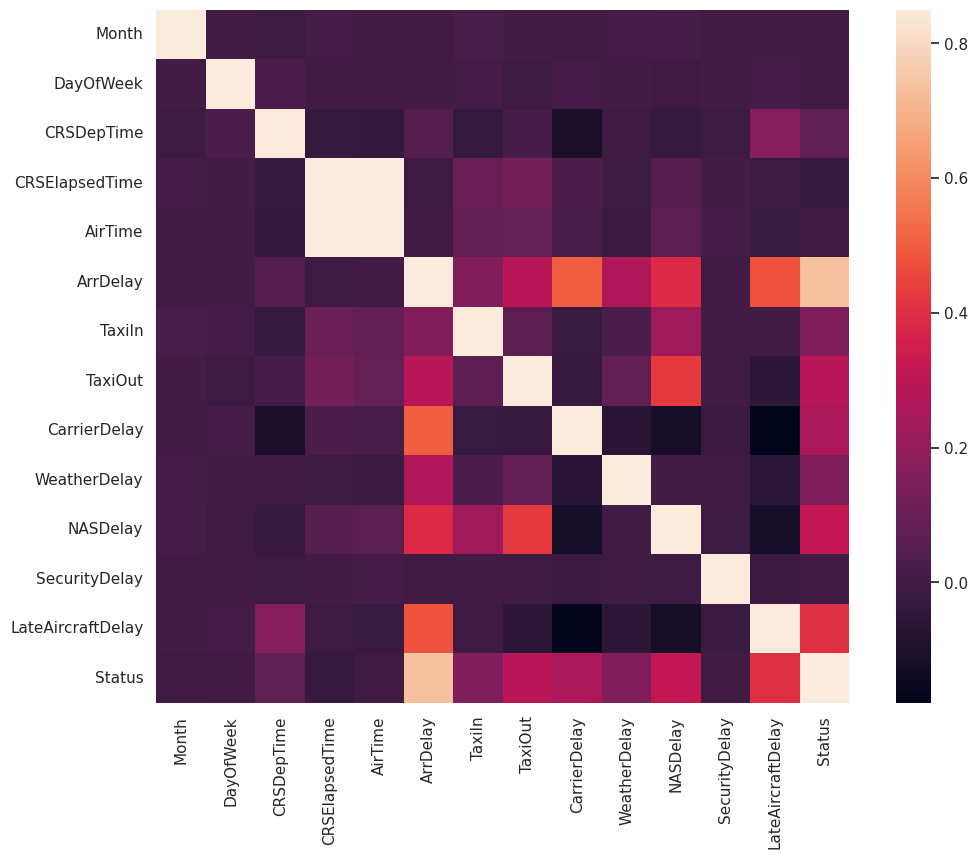

In [30]:
numeric_flights = flights.select_dtypes(include=[np.number])
corrmat = numeric_flights.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.85, square=True)
plt.show()

From the correlation matrix, we observe multicollinearity among the 29 variables, meaning some can be predicted by others. To streamline our analysis, we'll remove redundant variables and introduce new ones. Key takeaways include:

1. Data on delay causes is only present when Arrival Delay exceeds 15 minutes. This delay is a combination of CarrierDelay, WeatherDelay, NASDelay, and LateAircraftDelay. Cancelled or      diverted flights don't provide delay causes.

2. Airports and carriers often overestimate CRSElapsedTime compared to the actual time for Taxi In, Taxi Out, and Airtime. Thus, punctual departures often lead to early arrivals,          helping offset potential subsequent flight delays.

**Feature Engineering**

Creating a new feature named 'DepDate', which represents the departure date in the format 'YYYY-MM-DD' for readability

In [4]:
flights['DepDate'] = pd.to_datetime(flights.Year*10000+flights.Month*100+flights.DayofMonth,format='%Y%m%d')

**Data Transformation and Cleanup**

For a more structured analysis, we categorize flight statuses based on their delay and other attributes. Additionally, we transform the 'CancellationCode' from lettered to numerical values for easier processing. Lastly, dropping several columns that might not be necessary for our analysis or might be redundant.

**Delay Code**
* Status 0: "On-time"
* Status 1: "Slightly Delayed"
* Status 2: "Very Delayed
* Status 3: "Diverted"
* Status 4: "Cancelled"

**Cancel Code**
* Code 0: "Carrier"
* Code 1: "Weather"
* Code 2: "NAS"

In [5]:
for dataset in flights:
    flights.loc[flights['ArrDelay'] <= 15, 'Status'] = 0
    flights.loc[flights['ArrDelay'] >= 15, 'Status'] = 1
    flights.loc[flights['ArrDelay'] >= 60, 'Status'] = 2
    flights.loc[flights['Diverted'] == 1, 'Status'] = 3
    flights.loc[flights['Cancelled'] == 1, 'Status'] = 4

columns_to_drop = ["Unnamed: 0", "Year", "DayofMonth", "DepTime", "DepDelay", "ArrTime", "CRSArrTime", "ActualElapsedTime", "Diverted", "Cancelled", "Distance", "FlightNum", "TailNum"]
flights = flights.drop(columns=columns_to_drop)

# Data Analysis


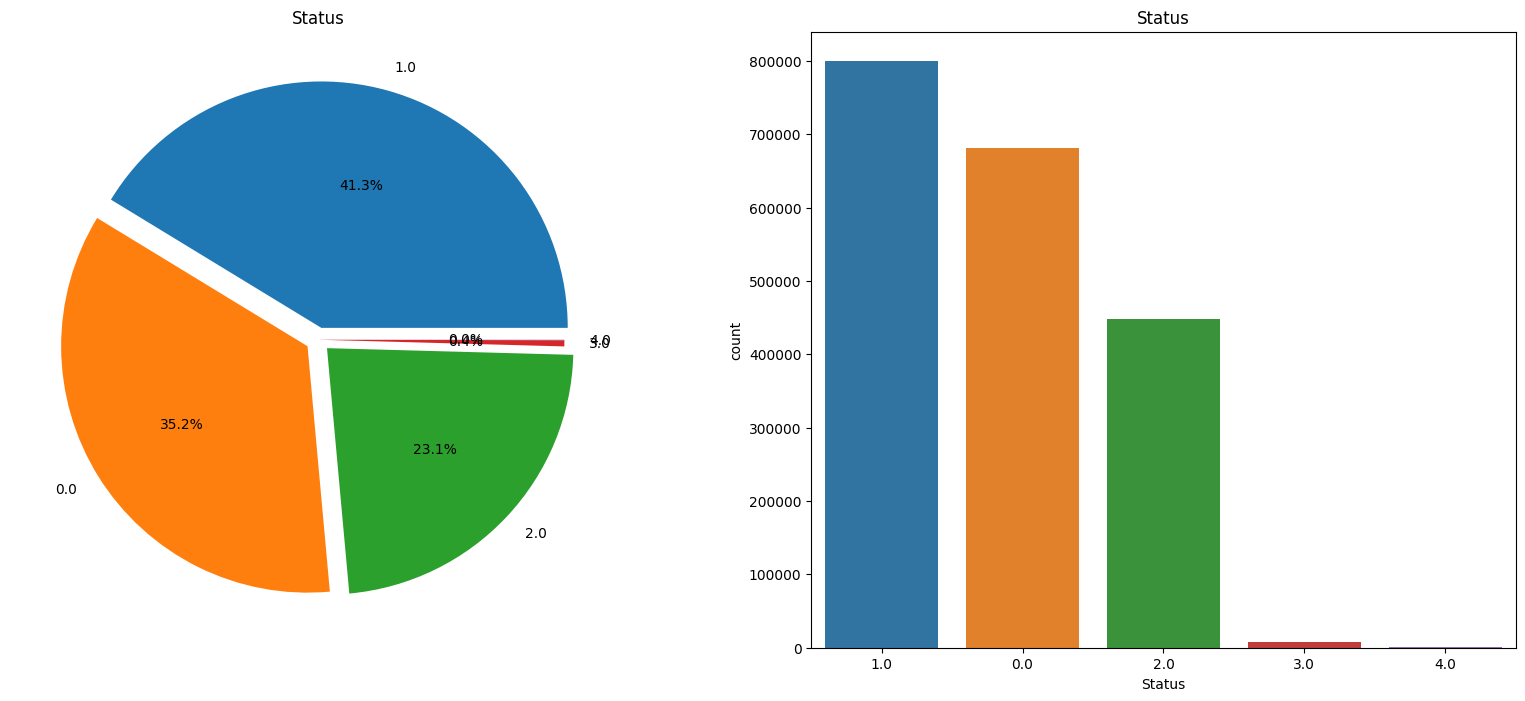

Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)


In [6]:
f,ax=plt.subplots(1,2,figsize=(20,8))
flights['Status'].value_counts().plot.pie(explode=[0.05, 0.05, 0.05, 0.0,0.0],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('Status')
ax[0].set_ylabel('')
sns.countplot(x='Status', order=flights['Status'].value_counts().index, data=flights, ax=ax[1])
ax[1].set_title('Status')
plt.show()


print('Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)')

# Delayed Flights

In [7]:
Delayedflights = flights[(flights.Status >= 1) &(flights.Status < 3)]

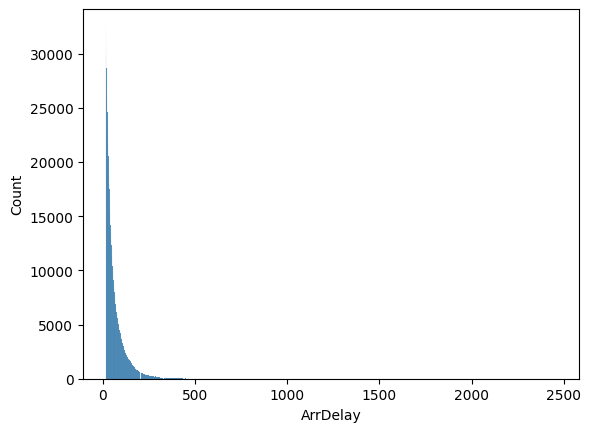

In [8]:
sns.histplot(Delayedflights['ArrDelay'])
plt.show()

In [9]:
print("Skewness: %f" % Delayedflights['ArrDelay'].skew())
print("Kurtosis: %f" % Delayedflights['ArrDelay'].kurt())

Skewness: 4.059856
Kurtosis: 40.381941


The histogram, along with skewness and kurtosis indexes, show that most delays are short and on the left side of the graph. While longer delays are rare, they tend to be significantly extended in duration.






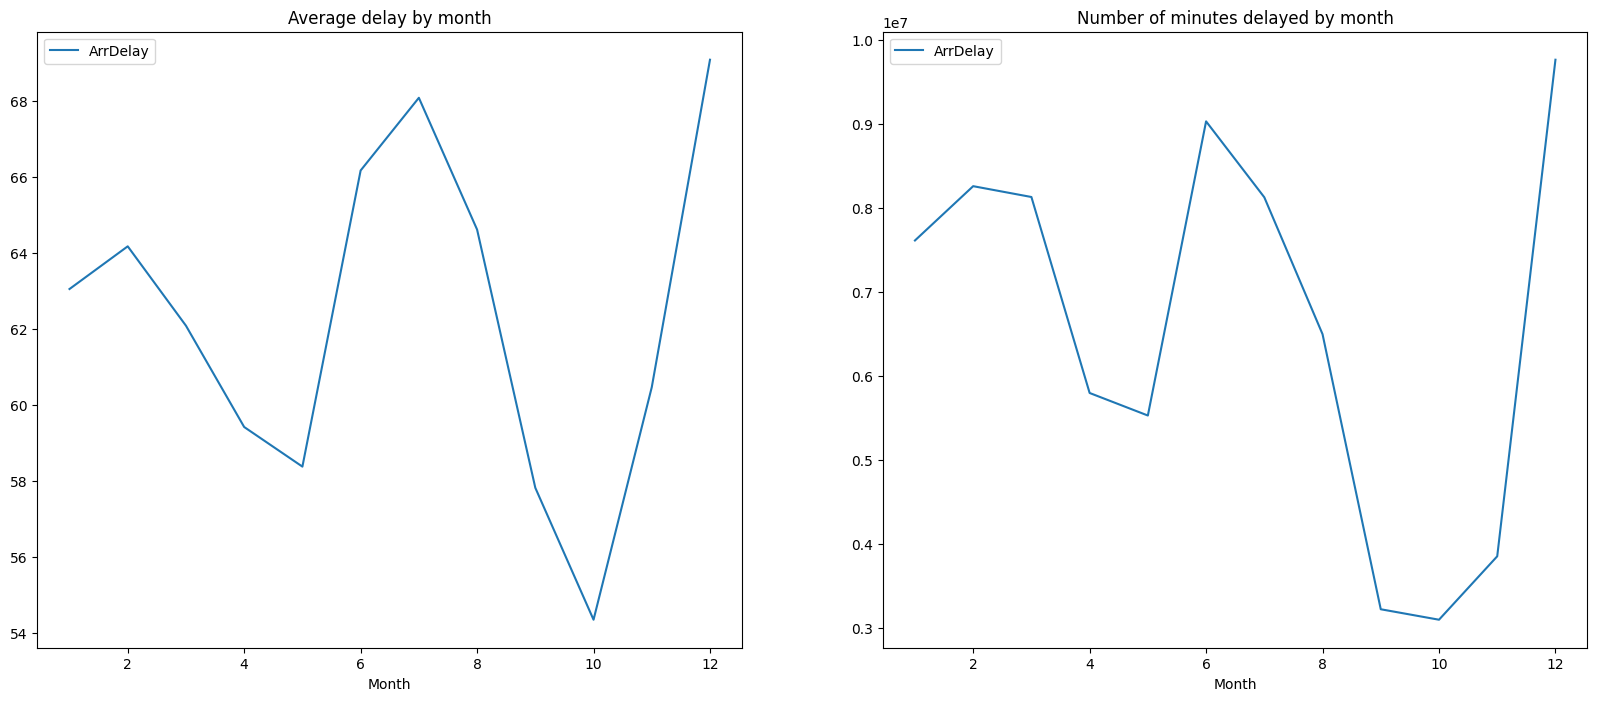

In [10]:
f,ax=plt.subplots(1,2,figsize=(20,8))
Delayedflights[['Month', 'ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month', 'ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

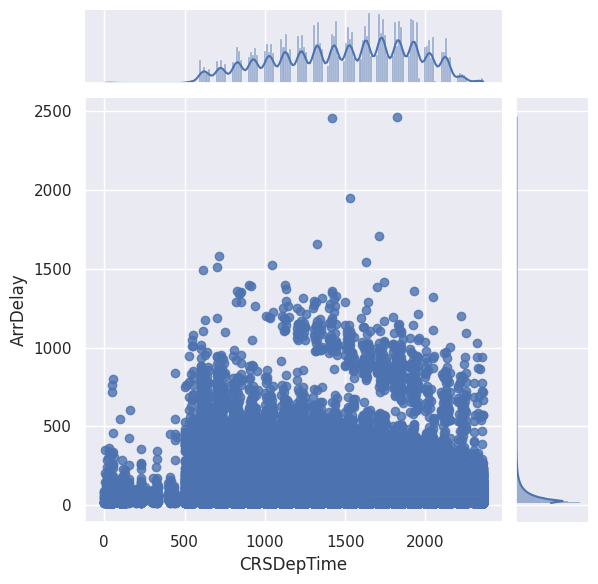

In [32]:
sns.jointplot(x='CRSDepTime', y='ArrDelay',data=Delayedflights, kind='reg', color='b', fit_reg = True)
plt.show()

Delays are usually in February, June and December.

The scatterplot shows how delays are concentrated in an hourly manner, as the day goes on, there are more and more delays, but in the centre it gets divided. This can be because of waiting for other delayed pax and/or aircraft rotation delays.

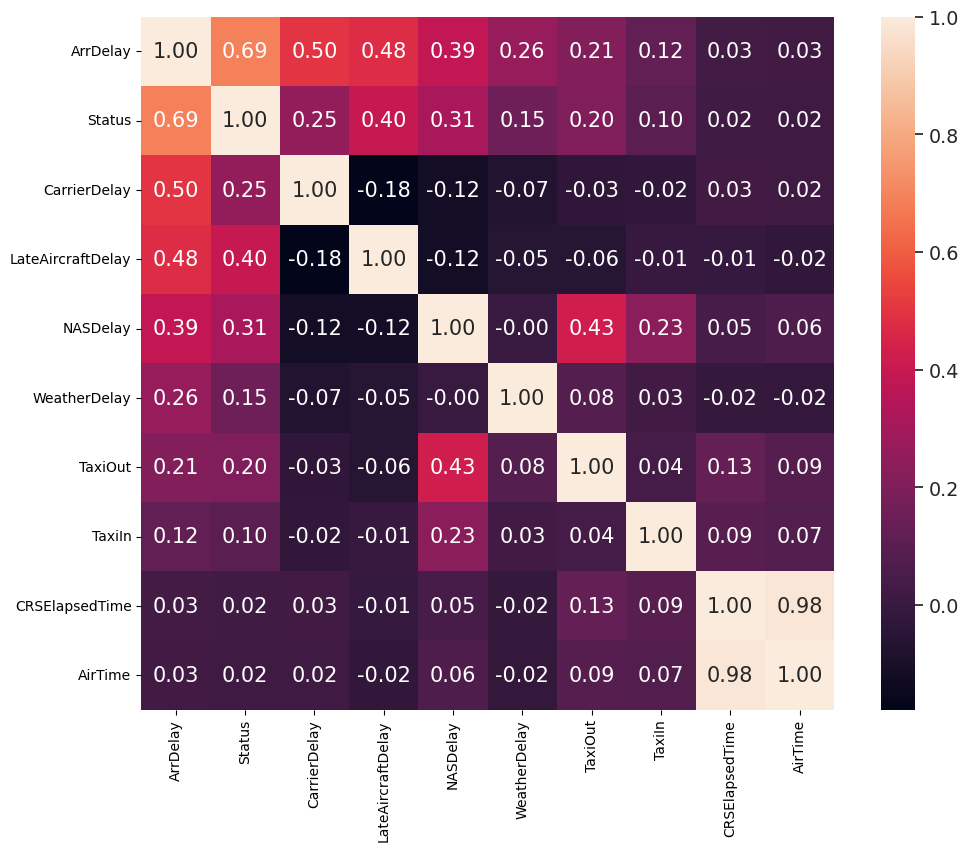

In [12]:
delcorrmat = Delayedflights.select_dtypes(include=[np.number]).corr()
k = 10
cols = delcorrmat.nlargest(k, 'ArrDelay')['ArrDelay'].index
f, ax = plt.subplots(figsize=(12, 9))
cm = delcorrmat.loc[cols, cols]
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

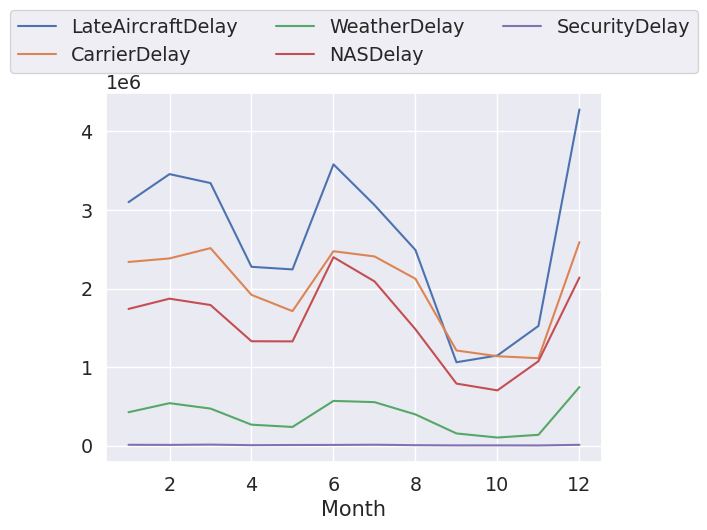

In [13]:
df2 = Delayedflights.filter(['Month','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], axis=1)
df2 = df2.groupby('Month')[['LateAircraftDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay']].sum().plot()
df2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
plt.show()

Correlation matrix identifies main variables for delays: Late Aircraft Delay, Carrier Delay and NAS Delay. The graph further proves the correlation matrix, showing that these are the most common delays during the year. Status is created ad hoc and should not be taken into account, CRSElapsedTime and AirTime also has by nature high correlation.

# Rotation Aircraft Delay

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


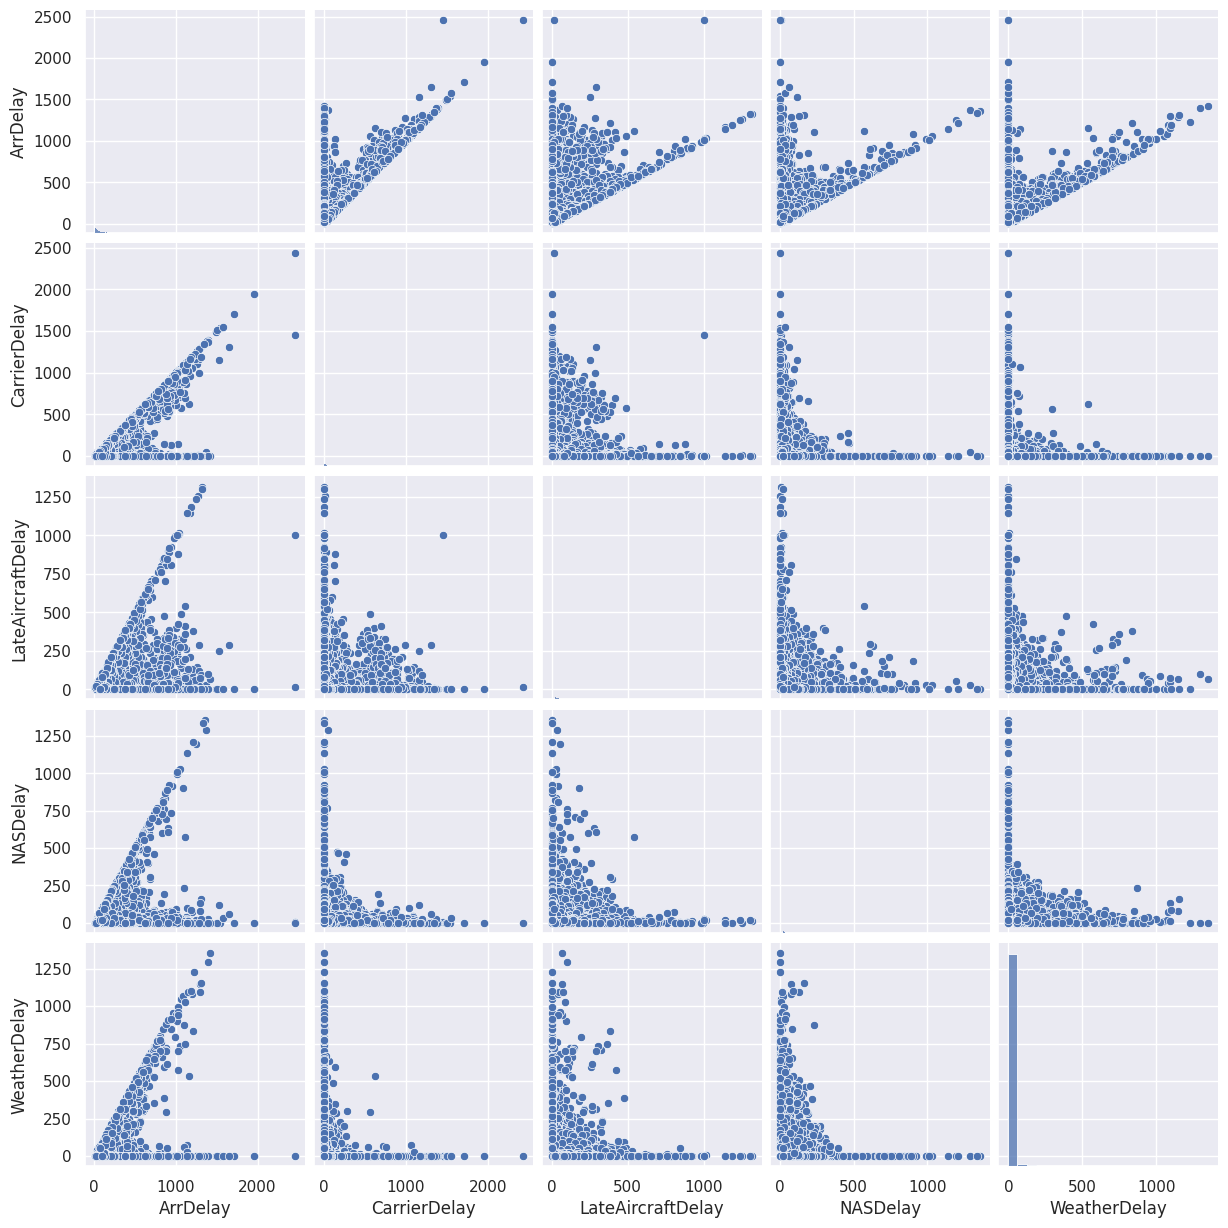

In [14]:
sns.set()
cols = ['ArrDelay', 'CarrierDelay', 'LateAircraftDelay', 'NASDelay', 'WeatherDelay']
sns.pairplot(Delayedflights[cols],height=2.5)
plt.show()

The Late Aircraft Delay is crucial primarily because of its extended wait times. Other delays amplify its impact due to a domino effect. Its pattern is similar to the NAS Delay, resulting from combined effects of other delays, offset by any time saved during the flight. However, the scatterplot doesn't show a strong link between different delay types. 

# Carrier Delays

In [15]:
print(flights['UniqueCarrier'].value_counts())

UniqueCarrier
WN    377602
AA    191865
MQ    141920
UA    141426
OO    132433
DL    114238
XE    103663
CO    100195
US     98425
EV     81877
NW     79108
FL     71284
YV     67063
B6     55315
OH     52657
9E     51885
AS     39293
F9     28269
HA      7490
AQ       750
Name: count, dtype: int64


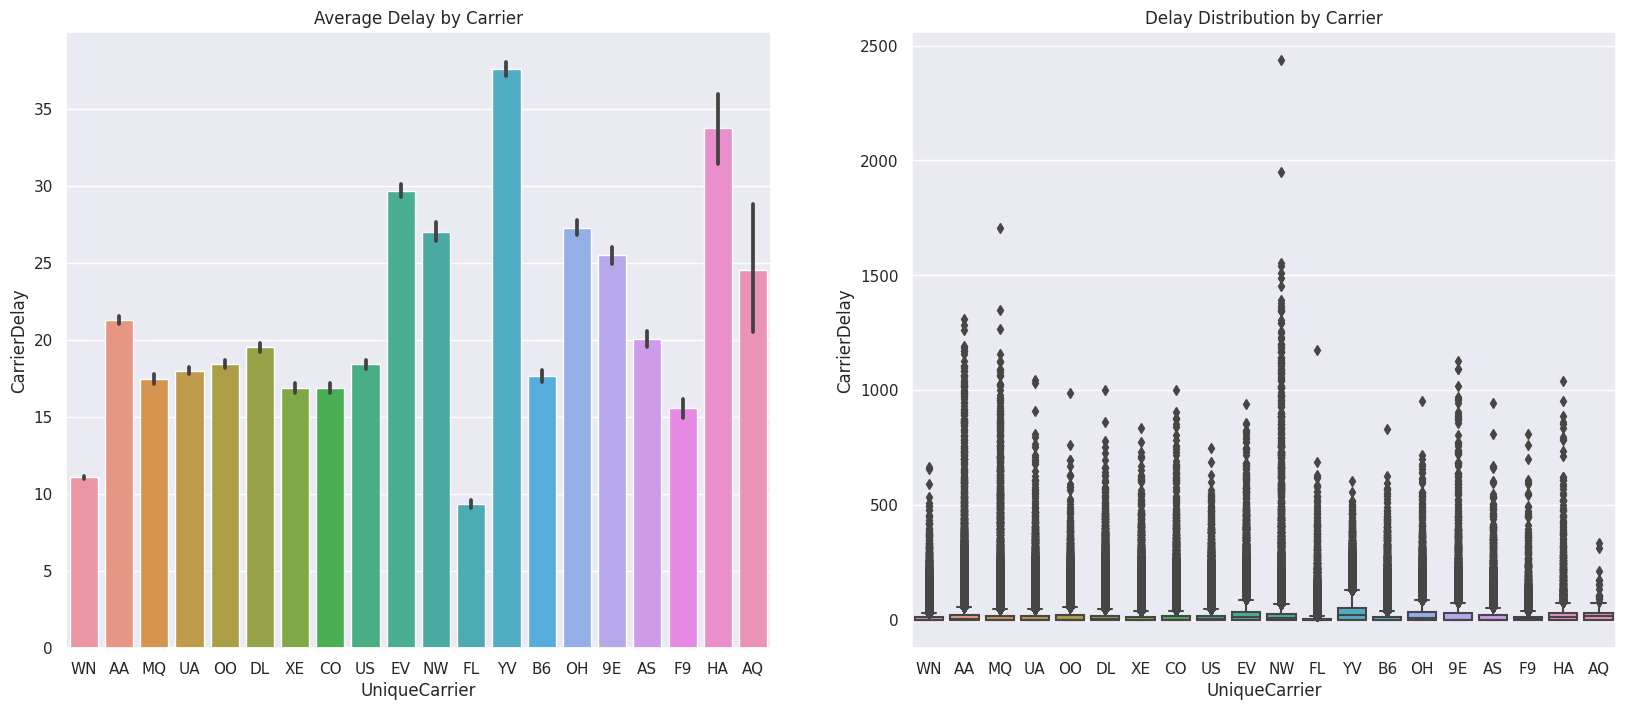

['WN: Southwest Airlines', 'AA: American Airlines', 'MQ: American Eagle Airlines', 'UA: Skywest Airlines', 'DL: Delta Airlines', 'XE: ExpressJet', 'CO: Continental Airlines', 'EV: Atlantic Southeast Airlines', 'NW: Northwest Airlines', 'FL: AirTran Airways', 'YV: JetBlue Airways', 'OH: Comair', '9E: Pinnacle Airlines', 'AS: Alaska Airlines', 'F9: Hawaiian Airlines', 'AQ: Aloha Airlines']


In [16]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='UniqueCarrier', y='CarrierDelay', data=Delayedflights, ax=ax[0], order=['WN', 'AA', 'MQ', 'UA','OO','DL','XE','CO',
                                                                                'US','EV', 'NW','FL','YV', 'B6','OH','9E',
                                                                                 'AS','F9','HA','AQ'])
sns.boxplot(x='UniqueCarrier', y='CarrierDelay', data=Delayedflights, ax=ax[1], order=['WN', 'AA', 'MQ', 'UA','OO','DL','XE','CO',
                                                                                'US','EV', 'NW','FL','YV', 'B6','OH','9E',
                                                                                 'AS','F9','HA','AQ'])

ax[0].set_title('Average Delay by Carrier')
ax[1].set_title('Delay Distribution by Carrier')
plt.close(2)
plt.show()

print(['WN: Southwest Airlines', 'AA: American Airlines', 'MQ: American Eagle Airlines', 'UA: Skywest Airlines', 'DL: Delta Airlines', 'XE: ExpressJet', 'CO: Continental Airlines',
       'EV: Atlantic Southeast Airlines', 'NW: Northwest Airlines', 'FL: AirTran Airways', 'YV: JetBlue Airways', 'OH: Comair', '9E: Pinnacle Airlines', 'AS: Alaska Airlines', 'F9: Hawaiian Airlines', 'AQ: Aloha Airlines'])

4 out of the top 5 airlines in the domestic market, Southwest Airlinse, American Eagle Airlines, United Airlines and Skywest Airlines, create an average delay below the mean (19 minutes).

Carriers with higher average delays are Mesa Airlines, Hawaian Airlines and ExpressJet, ranging from 30 minutes to 40 minutes average.

# NAS Delay

In [17]:
Top20airports = Delayedflights[(Delayedflights.Origin == 'ORD') | (Delayedflights.Origin == 'ATL') |
                               (Delayedflights.Origin == 'DFW') | (Delayedflights.Origin == 'DEN') |
                               (Delayedflights.Origin == 'EWR') | (Delayedflights.Origin == 'LAX') | 
                               (Delayedflights.Origin == 'IAH') | (Delayedflights.Origin == 'PHX') |
                               (Delayedflights.Origin == 'DTW') | (Delayedflights.Origin == 'SFO') | 
                               (Delayedflights.Origin == 'LAS') | (Delayedflights.Origin == 'DEN') |
                               (Delayedflights.Origin == 'ORD') | (Delayedflights.Origin == 'JFK') | 
                               (Delayedflights.Origin == 'CLT') | (Delayedflights.Origin == 'LGA') |
                               (Delayedflights.Origin == 'MCO') | (Delayedflights.Origin == 'MSP') | 
                               (Delayedflights.Origin == 'BOS') | (Delayedflights.Origin == 'PHL')]

print(Top20airports['Origin'].value_counts())

Origin
ORD    90611
ATL    87741
DFW    62073
DEN    46477
EWR    36115
LAX    33713
IAH    33166
PHX    31002
DTW    30732
SFO    30110
LAS    30041
JFK    23870
CLT    23318
LGA    22807
MCO    22290
MSP    22149
BOS    19816
PHL    19302
Name: count, dtype: int64


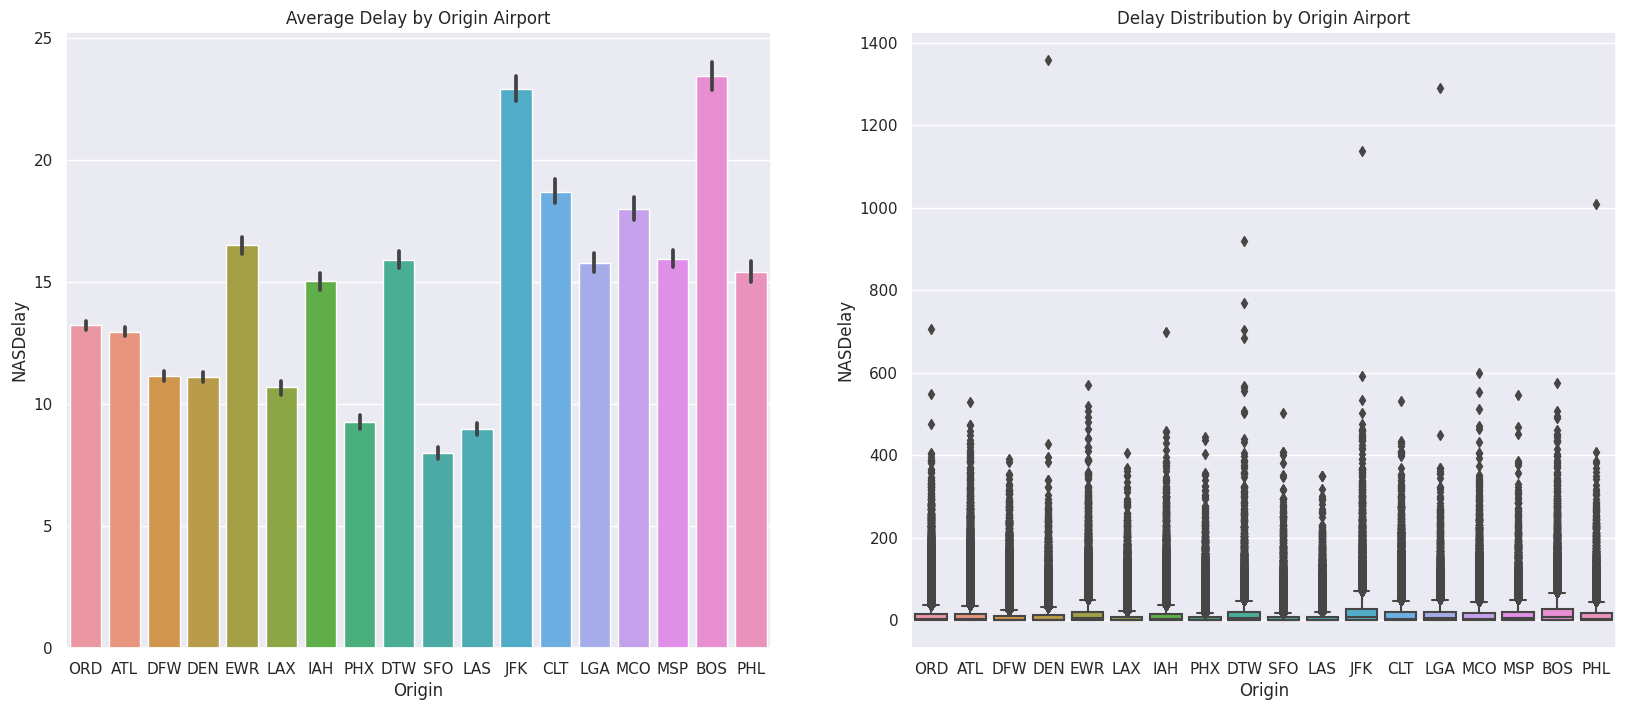

['ORD: Chicago', 'ATL: Atlanta', 'DFW: Dallas Fortworth', 'DEN: Denver', 'EWR: Newark', 'LAX: Los Ángeles', 'IAH: Houston', 'PHX: Phoenix', 'DTW: Detroit', 'SFO: San Francisco', 'LAS: Las Vegas', 'JFK: New York', 'CLT: Charlotte', 'LGA: La Guardia (NY)', 'MCO: Orlando', 'MSP: Minneapolis', 'BOS Boston', 'PHL Philadelphia']


In [18]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot(x='Origin',y='NASDelay', data=Top20airports,ax=ax[0], order=['ORD', 'ATL', 'DFW', 'DEN','EWR','LAX','IAH','PHX','DTW',
                                                                     'SFO', 'LAS','JFK','CLT', 'LGA','MCO','MSP','BOS','PHL'])
ax[0].set_title('Average Delay by Origin Airport')
sns.boxplot(x='Origin',y='NASDelay', data=Top20airports,ax=ax[1], order=['ORD', 'ATL', 'DFW', 'DEN','EWR','LAX','IAH','PHX','DTW',
                                                                     'SFO', 'LAS','JFK','CLT', 'LGA','MCO','MSP','BOS','PHL'])
ax[1].set_title('Delay Distribution by Origin Airport')
plt.close(2)
plt.show()

print(['ORD: Chicago', 'ATL: Atlanta', 'DFW: Dallas Fortworth', 'DEN: Denver','EWR: Newark','LAX: Los Ángeles',
       'IAH: Houston','PHX: Phoenix','DTW: Detroit','SFO: San Francisco','LAS: Las Vegas','JFK: New York','CLT: Charlotte',
       'LGA: La Guardia (NY)','MCO: Orlando','MSP: Minneapolis','BOS Boston','PHL Philadelphia'])

The data suggests a link between the number of flights and NASDelay, though Newark, Houston, and Detroit are exceptions. Delays tend to decrease from Chicago to Las Vegas but rise again in smaller airports with under 30,000 flights yearly. However, this trend isn't solid as the data only covers domestic flights, while airports like LAX, JFK, and Atlanta have more traffic due to international flights. So, it's wise to take these findings lightly.